## Import Libraries

In [84]:
import os
import bokeh
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from bokeh.io import output_notebook, curdoc, reset_output
from bokeh.plotting import figure, output_file, show, ColumnDataSource, save
output_notebook() 

Loading BokehJS ...

## Read Data and Set Directories

In [2]:
data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data')
result_dir = os.path.join(os.path.dirname(os.getcwd()), 'results')
thumbnail_dir = os.path.join(data_dir, 'thumbnail')

if not os.path.exists(thumbnail_dir):
    os.makedirs(thumbnail_dir)

In [3]:
hayao_pics = pd.read_csv(os.path.join(data_dir, 'hayao_pics.csv'))
disney_pics = pd.read_csv(os.path.join(data_dir, 'disney_pics.csv'))

In [118]:
def MinMaxScale(lst):
    lst_max, lst_min = np.max(lst), np.min(lst)
    return [(x - lst_min) / (lst_max - lst_min) for x in lst]

In [120]:
hayao_pics['mean_entropy_scaled'] = MinMaxScale(hayao_pics['mean_entropy'])
disney_pics['mean_entropy_scaled'] = MinMaxScale(disney_pics['mean_entropy'])

In [ ]:
all_pics = pd.concat([hayao_pics, disney_pics])
all_pics['studio'] = ['Hayao'] * hayao_pics.shape[0] + ['Disney'] * disney_pics.shape[0]

In [4]:
hayao_thumbnail_dir = os.path.join(thumbnail_dir, 'hayao_thumbnail')
if not os.path.exists(hayao_thumbnail_dir):
    os.makedirs(hayao_thumbnail_dir)
    
disney_thumbnail_dir = os.path.join(thumbnail_dir, 'disney_thumbnail')
if not os.path.exists(disney_thumbnail_dir):
    os.makedirs(disney_thumbnail_dir)

## Plot Image Features

### Boxplots of Image Features

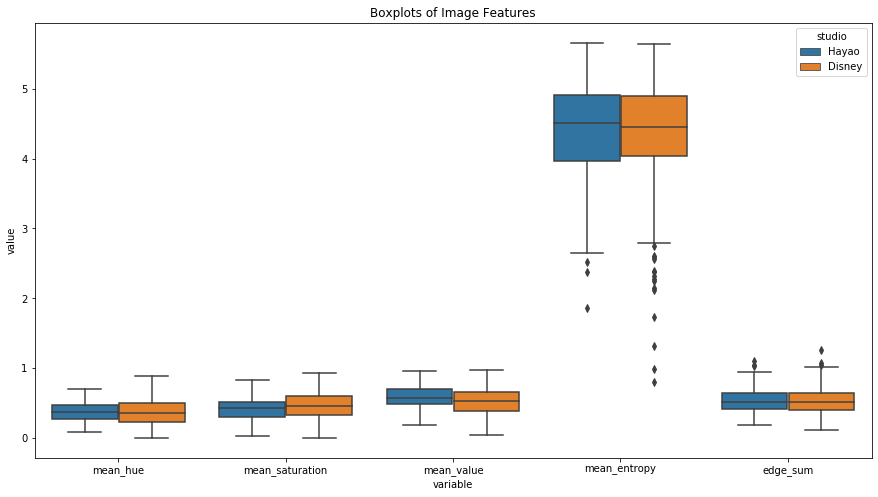

In [78]:
data = pd.melt(all_pics[['mean_hue', 'mean_saturation', 'mean_value', 'mean_entropy', 'edge_sum', 'studio']], 'studio')
fig, ax = plt.subplots(figsize = (15, 8))
ax = sns.boxplot(x = "variable", y = "value", hue = 'studio', data = data)
ax.set_title('Boxplots of Image Features')
plt.savefig(os.path.join(result_dir, 'Boxplots of Image Features.jpg'))

### Pairplots of Image Features

In [113]:
feature_list = ['mean_hue', 'mean_saturation', 'mean_value', 'mean_entropy', 'edge_sum', 'studio']

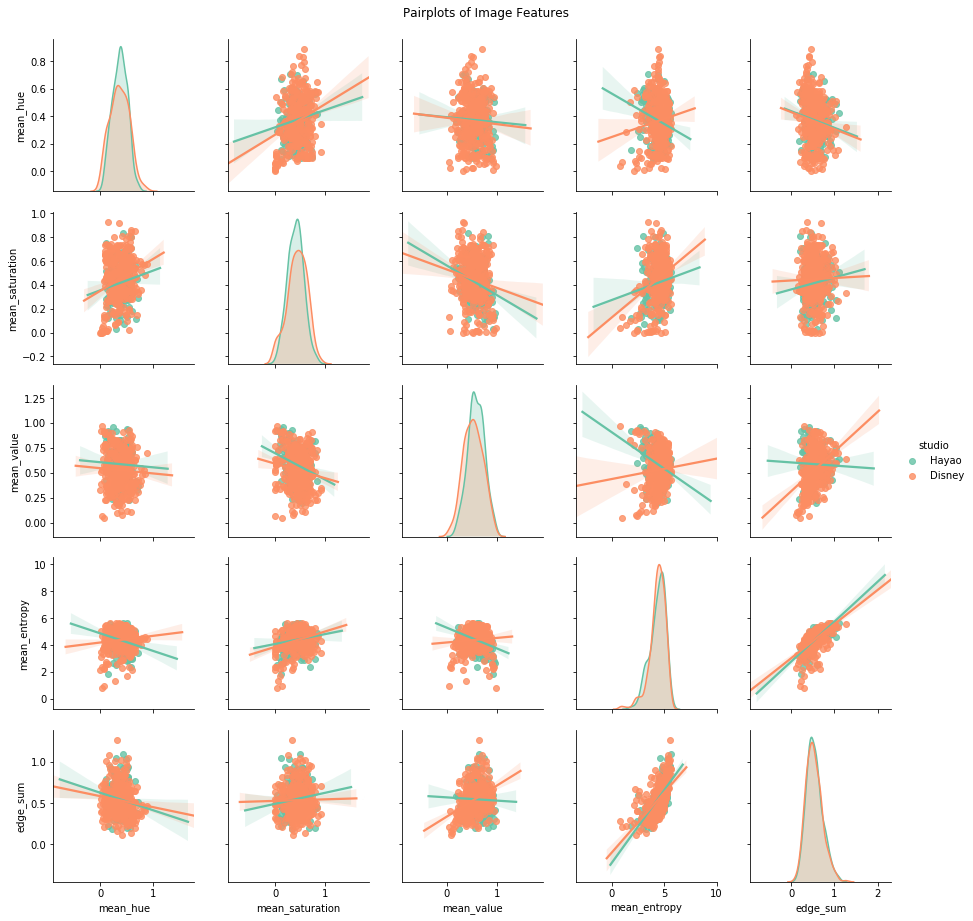

In [117]:
pairplot = sns.pairplot(all_pics[feature_list], palette = "Set2", kind = 'reg', hue = 'studio')
pairplot.fig.suptitle('Pairplots of Image Features', y = 1.02)
pairplot.savefig(os.path.join(result_dir, 'Pairplots of Image Features.jpg'))

## Make Thumbnails of Images

In [ ]:
def make_thumbnail(image_name, image_path, thumbnail_dir, size):
    image = Image.open(image_path)
    image.thumbnail(size)
    thumbnail_path = os.path.join(thumbnail_dir, image_name + '_thumbnail.jpg')
    image.save(thumbnail_path)

In [ ]:
size = (128, 128)
hayao_image_dir = os.path.join(data_dir, 'images/images_hayao')
disney_image_dir = os.path.join(data_dir, 'images/images_disney')

In [106]:
for img in os.listdir(hayao_image_dir):
    if img.endswith('.jpg'):
        img_path = os.path.join(hayao_image_dir, img)
        img_name = os.path.splitext(img)[0]
        make_thumbnail(img_name, img_path, hayao_thumbnail_dir, size)
    
for img in os.listdir(disney_image_dir):
    if img.endswith('.jpg'):
        img_path = os.path.join(disney_image_dir, img)
        img_name = os.path.splitext(img)[0]
        make_thumbnail(img_name, img_path, disney_thumbnail_dir, size)

## Make Bitmaps

In [9]:
def make_bitmap(name, df, feature1, feature2, thumbnail_dir, size, color, result_dir):
    figure = Image.new('RGB', (size, size), color)
    i = 0
    for i in range(df.shape[0]):
        thumbnail_path = os.path.join(thumbnail_dir, str(df['name'].iloc[i]) + '_thumbnail.jpg')
        thumbnail = Image.open(thumbnail_path)
        coordinates = int(df[feature1].iloc[i] * size), int(df[feature2].iloc[i] * size)
        figure.paste(thumbnail, coordinates)
    figure_path = os.path.join(result_dir, '{} {} vs. {}.jpg'.format(name, feature1, feature2))
    figure.save(figure_path)
    
    image = plt.imread(figure_path)
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.imshow(image)
    ax.axis('off')
    ax.set_title('{} {} vs. {}'.format(name, feature1, feature2))   

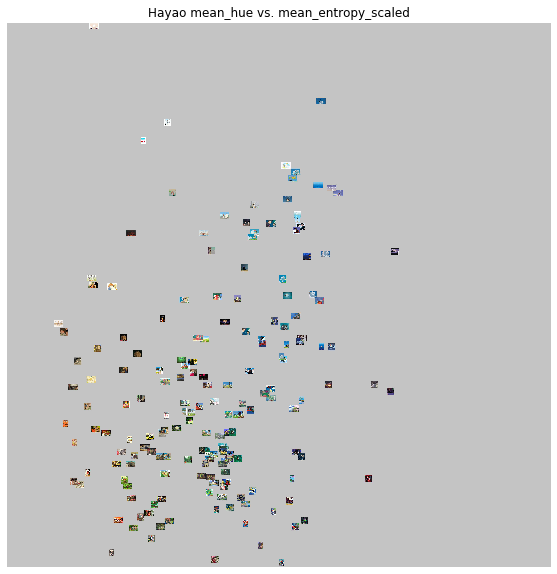

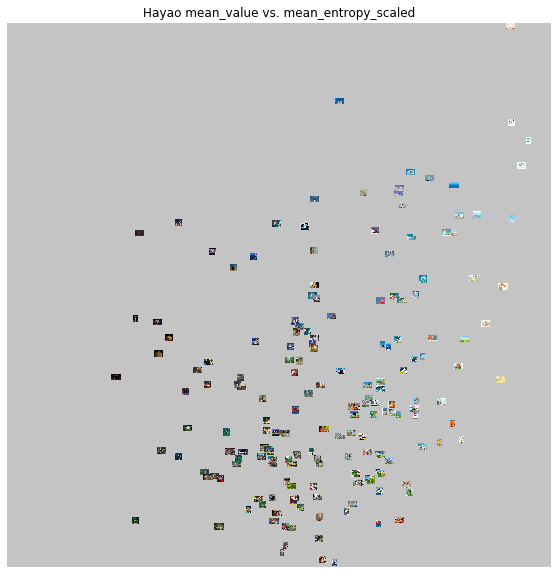

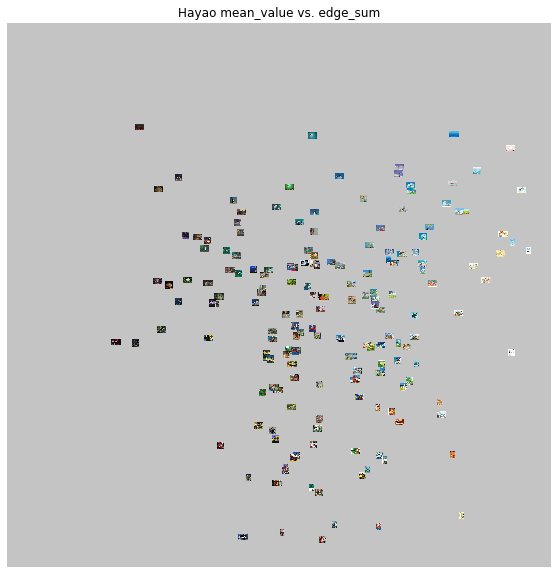

In [124]:
make_bitmap('Hayao', hayao_pics, 'mean_hue', 'mean_entropy_scaled', hayao_thumbnail_dir, 7500, (196, 196, 196), result_dir)
make_bitmap('Hayao', hayao_pics, 'mean_value', 'mean_entropy_scaled', hayao_thumbnail_dir, 7500, (196, 196, 196), result_dir)
make_bitmap('Hayao', hayao_pics, 'mean_value', 'edge_sum', hayao_thumbnail_dir, 7500, (196, 196, 196), result_dir)

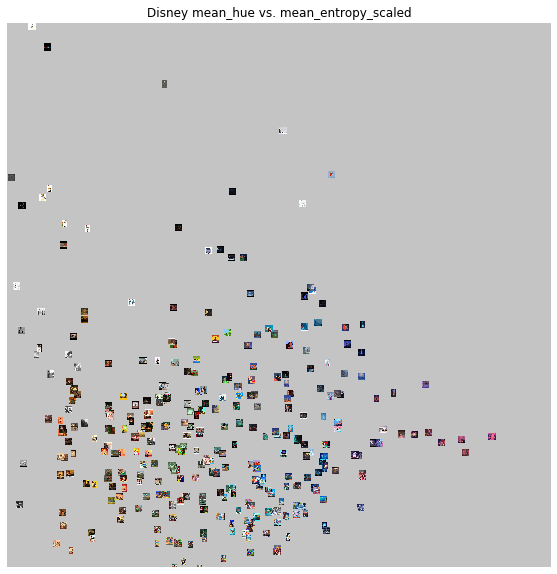

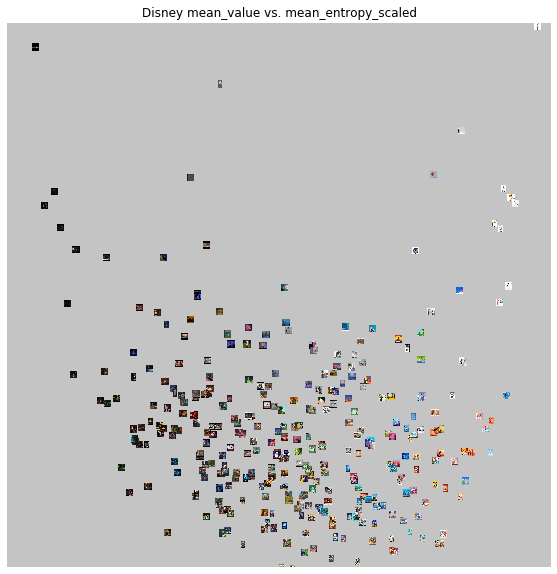

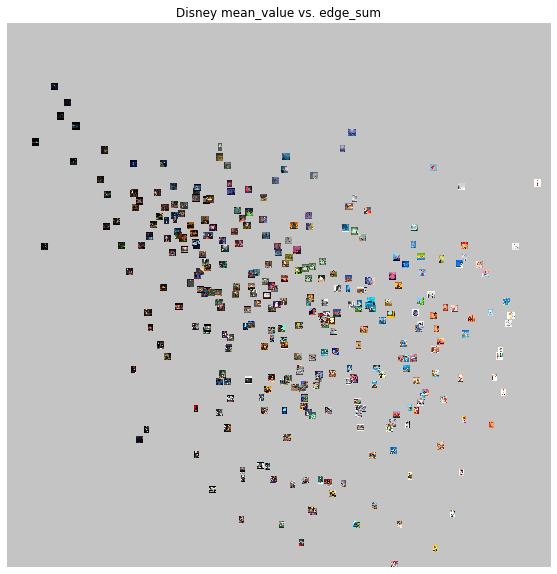

In [125]:
make_bitmap('Disney', disney_pics, 'mean_hue', 'mean_entropy_scaled', disney_thumbnail_dir, 7500, (196, 196, 196), result_dir)
make_bitmap('Disney', disney_pics, 'mean_value', 'mean_entropy_scaled', disney_thumbnail_dir, 7500, (196, 196, 196), result_dir)
make_bitmap('Disney', disney_pics, 'mean_value', 'edge_sum', disney_thumbnail_dir, 7500, (196, 196, 196), result_dir)

## Make Interactive Plots

In [128]:
def make_interactive(feature1, feature2, width, height):
    hayao_img_lst = ['https://raw.githubusercontent.com/ucsd-dsc-arts/dsc160-midterm-group9/master/data/images/images_hayao/' 
                + str(img_name) + '.jpg' for img_name in hayao_pics['name']] 
    disney_img_lst = ['https://raw.githubusercontent.com/ucsd-dsc-arts/dsc160-midterm-group9/master/data/images/images_disney/' 
                + str(img_name) + '.jpg' for img_name in disney_pics['name']] 
    hayao_source = ColumnDataSource(data = dict(
        x = list(hayao_pics[feature1]),
        y = list(hayao_pics[feature2]),
        img = hayao_img_lst,
        studios = ['Hayao'] * hayao_pics.shape[0]
    ))
    disney_source = ColumnDataSource(data = dict(
        x = list(disney_pics[feature1]),
        y = list(disney_pics[feature2]),
        img = disney_img_lst,
        studios = ['Disney'] * disney_pics.shape[0]
    ))
    

    TOOLTIPS = """
        <div>
            <div>
                <img
                    src="@img" height="128" alt="@img" width="128"
                    style="float: left; margin: 0px 15px 15px 0px;"
                    border="2"
                ></img>
            </div>
            <div>
                <span style="font-size: 15px; font-weight: bold;">@studios</span>
            </div>
            <div>
                <span style="font-size: 10px;">(@x, @y)</span>
            </div>
        </div>
    """

    p = figure(plot_width = width, plot_height = height, tooltips = TOOLTIPS, 
               title = '{} vs. {}'.format(feature1, feature2), x_axis_label = feature1, y_axis_label = feature2)

    p.circle('x', 'y', size = 10, source = hayao_source, color = 'lightcoral', legend_label = 'Hayao')
    p.circle('x', 'y', size = 10, source = disney_source, color = 'cornflowerblue', legend_label = 'Disney')
    
    output_file(os.path.join(result_dir, '{} vs. {}.html'.format(feature1, feature2)))
    save(p)   

In [130]:
make_interactive('mean_hue', 'mean_entropy', 800, 600)
make_interactive('mean_value', 'mean_entropy', 800, 600)
make_interactive('mean_value', 'edge_sum', 800, 600)

## WordClouds

In [ ]:
hayao_plot = 
hayao_plot_keywords = 
hayao_wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = set(STOPWORDS), 
                min_font_size = 10).generate(hayao_plot_keywords) 
                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(hayao_wordcloud) 
plt.axis("off") 
plt.title('Hayao Movie Plot Keywords')
plt.show() 

In [ ]:
disney_plot = 
disney_plot_keywords = 
disney_wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = set(STOPWORDS), 
                min_font_size = 10).generate(disney_plot_keywords) 
                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(disney_wordcloud) 
plt.axis("off") 
plt.title('Disney Movie Plot Keywords')
plt.show() 